# Integrating boolean cell cycle models with constraint-based model of metabolism

In this notebook I show a simple example of a model that integrates two off-the-shelf models. One is a logical model of the cell cycle, as presented in Linke (2017), the other a model of yeast metabolism as presented in Aung, Henry & Walker (2013). 

>The cells are hierarchically dependent on each other, meanning that the upper cells have to be executed for the lower cells to be able to run. 

(This method is chosen above creating and importing modules to allow to easily see what is under the hood of the algorithm)

References
-  Aung, H. W., Henry, S. A., & Walker, L. P. (2013). Revising the representation of fatty acid, glycerolipid, and glycerophospholipid metabolism in the consensus model of yeast metabolism. Industrial biotechnology, 9(4), 215-228.
-  Linke, C., Chasapi, A., González-Novo, A., Al Sawad, I., Tognetti, S., Klipp, E., ... & Barberis, M. (2017). A Clb/Cdk1-mediated regulation of Fkh2 synchronizes CLB expression in the budding yeast cell cycle. npj Systems Biology and Applications, 3, 1.

# First, packages and data are imported
Execute this cell first. Loading the yeast7 map will probably prompt some warning messages about capitalized 'AND/OR' rules, ignore this.

In [2]:
#Import Booleannet's Model for simulating boolean networks
from boolean2 import Model

#Import cobra for loading metabolic map, and pfba / fva for analyzing constraint-based networks
import cobra
from cobra.flux_analysis import pfba
from cobra.flux_analysis import flux_variability_analysis as fva

#Import json to load and save files as .json
import json

# Import matplotlib for visualizing in plots, and pandas to store and visualize in tabular format. Ipython's display displays
# a.o. pandas dataframes
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

#Import visualisation functions from utils
from utils import visualize

# Make plots appear within the notebook
%matplotlib inline

#Load map from 'models' folder. D
yeast7 = cobra.io.load_json_model("models/yeast_7.6_KEGG-rxn.json")

# Barberis cell cycle model

This cell contains the Barberis cell cycle model in text format. The text format model serves as input for Booleannet to simulate the network. The first 4 lines represent the nodes initial state. The other block of text represents the rules to update the nodes indicated with an asterix.

The functionality of the booleannet functions report_cycles, and detect_cycles() are showcased. These respectively return a tuple, and a text to indicate the (first) occurence of a cycle, and the cycle length 

Cycle of length 7 starting at index 0
(0, 7)


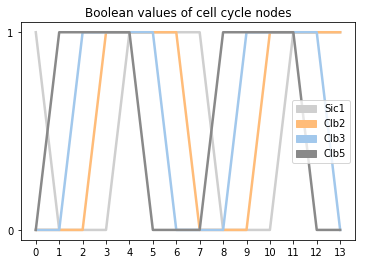

,Clb2,Clb3,Clb5,Sic1
0,False,False,False,True
1,False,False,True,False
2,False,True,True,False
3,True,True,True,False
4,True,True,True,True
5,True,True,False,True
6,True,False,False,True
7,False,False,False,True
8,False,False,True,False
9,False,True,True,False


In [3]:
Barberis_2_txt = """
Sic1 = True
Clb2 = False
Clb3 = False
Clb5 = False

Sic1* = Clb2
Clb2* = Clb3
Clb3* = Clb5
Clb5* = not (Clb2 and Sic1)
"""

#Initialize and run the bool_m
bool_m = Model(text = Barberis_2_txt, mode = 'sync')
bool_m.initialize()
bool_m.iterate( steps= 13)

#Detect and report on cycles in the Boolean attractor
bool_m.report_cycles()
print bool_m.detect_cycles()

#Plot results
nodes = ['Sic1','Clb2','Clb3','Clb5']
lines = []
#Color palette used for plots
color_blind_hex = ['#006ba4','#ff800e','#ababab','#595959','#5f9ed1','#c85200','#898989','#a2c8ec','#ffbc79','#cfcfcf']
for node in nodes:
    colour = color_blind_hex.pop()
    line = plt.plot(bool_m.data[node], colour, linewidth = 2.5)
    line = mpatches.Patch(color=colour, label=node)
    lines.append(line)
plt.yticks( (0,1) )
plt.xticks(range(14))
plt.title("Boolean values of cell cycle nodes")
plt.legend(handles=lines)

# To save the plot, specify a plot name after figures/, end with .png. Note: will overwrite without warning! 
# plt.savefig("figures/") 

#Display plot inline
plt.show()      
    
#Create a dataframe from the boolean data, and display in line
clean_bool_df = pd.DataFrame.from_dict(bool_m.data)
display(clean_bool_df)

# Under the hood. The functions running the algorithm

Below you find the functions and classes that make up the algorithm that simulates the model. 

- Directly below is an oversight function that takes input, makes sure that all the functions are executed in the right order, and outputs simulation results.

- Below that are the functions that are called when executing run. These include the functions for automatically creating a boolean network based on the interaction objects, functions that create edges between the two models, and a function to aid in saving individual flux distributions.

- Finally two classes are defined in which the interactions can be specified and collected

In [4]:
def run(interaction_objects,cobra_m,CDC_text_model,rxn_order_in_file_name,solution_path,iterations=15):
    """Oversight function to connect the logical and COBRA submodels and run the algorithm in the right order.
    Output is a dataframe with all the flux distributions, and a dictionary containing the boolean states.
    """
    ############################################################################################
    MtoCgenes = [interx.metabolic_gene for interx in interaction_objects if interx.interaction_rule[:4] == 'MtoC']
    def set_met_value( state, name, value, p ):
        """Updates COBRA nodes in logical model according to flux distribution in COBRA model. 
        Ignores other nodes in the logical model.
        ------------------------------------------------------------------------------------------
        Input:
            name    Name of COBRA node in logical model, is equal to gene_name in COBRA model
            state   Information on the iteration number
            value   Boolean value of the node
            p       Boolean parser from Boolleannet

            run-local variables:
            flux_distr    solution dictionary containing flux distribution
            cobra_m COBRA model

        HAS TO BE DEFINED WITHIN RUN ALGORITHM DUE TO NEED FOR RUN-LOCAL VARIABLES NEEDED FOR BOOLEANNET
        -------------------------------------------------------------------------------------------"""
        # set metabolic nodes in logical model to booleanized value from cobra model
        if name in MtoCgenes: #
            value = bool_from_cobra(name,cobra_m,flux_distr) #cobra_m, sol, and MtoCgenes have to be universal due to Booleannet architecture 

            # sets the node in Booleannet
            setattr( state, name, value )
            return value
    ##############################################################################################
    
    #ALGORITHM STARTS HERE
    #Check whether current interacting reactions match those used in previous simulation (if used)
    if rxn_order_in_file_name:
        actual_rxns = []
        for intx in interaction_objects:
            actual_rxns += [rxn.id for rxn in cobra_m.genes.get_by_id(intx.metabolic_gene)]
        assert set(actual_rxns) == set(rxn_order_in_file_name), "Error: rxns in solution path do not match rxns in interaction objects"
        print "Beware, previous solutions will be used, make sure that flux activation values are identical to previous simulation and no knock-outs have been conducted"
    
    #Initialize CDC model including COBRA_nodes
    CDC_COBRA_text_model = add_cobra_to_bool(interaction_objects,CDC_text_model)
    bool_m = Model(text = CDC_COBRA_text_model, mode = 'sync')
    bool_m.initialize()
    
    #Initialize dataframe for storing flux distributions
    flux_distr_df = pd.DataFrame()
    
    #Run simulation
    for i in range(iterations):
        
        #Get previously created flux distribution from directory or create using pFBA.
        lastbool = bool_m.last #Get latest boolean state of logical model
        flux_distr= cobra_from_bool(cobra_m,lastbool,interaction_objects,activation_flux_values,rxn_order_in_file_name,solution_path)
        flux_distr_df[i] = flux_distr
        
        #Update COBRA nodes in logical model using 'sol'. (Used by bool_m.iterate() through set_met_value())
        bool_m.parser.RULE_SETVALUE = set_met_value
        bool_m.iterate( steps = 1)
        
        #Update CDC nodes in logical model
        bool_m.parser.RULE_SETVALUE = set_value
        bool_m.iterate( steps = 1)
        
    return bool_m.data, flux_distr_df.round(decimals=9)

In [5]:
def add_cobra_to_bool(interaction_objects,bool_text):
    """Adjusts text-based boolean model to include COBRA nodes that can represent flux presence/absence
    Currently activating and inhibiting interactions are set using 'and rule': 
    "and <COBRA_node>", "and not <COBRA_node>" respectively. 
    """   
    #Split text-based model in a 'node initialization', and a 'rule' section
    init_txt = bool_text.split("\n\n")[0]
    rule_txt = bool_text.split("\n\n")[1]
    assert len(rule_txt) > 0, "bool text requires white space between initial values section and rules section %s" %bool_text
    
    #Initialize dicts that will contain updated init- and rule-text respectively
    init_dct = {}
    rule_dct = {}
    
    #Convert text-based to dict of strings for easy and fast manipulation
    rules = rule_txt.split("\n") #split to individual rules
    for line in rules:
        if '*' not in line: #skip empty lines
            continue
        target,rule=line.split('*') 
        rule = '* '+rule #add back delim
        rule_dct[target]=rule
        
    # Creates COBRA node initialisation line, to initialize as false.
    # Iterates over MtoC interactions to append bool_rules with a COBRA node rule.
    for interaction in interaction_objects:
        
        met_gene = interaction.metabolic_gene
        
        if interaction.interaction_rule == 'MtoC_inhib':
            #If multiple Met_enzymes act on one CDC node, key is overwritten
            init_dct[met_gene] = " = False" 
            rule_dct[interaction.cell_cycle_node]+= " and not %s" %met_gene #cell_cycle_node is target
            rule_dct[met_gene] = "* = %s" %met_gene 
        elif interaction.interaction_rule == 'MtoC_activ':
            #If multiple Met_enzymes act on one CDC node, key is overwritten
            init_dct[met_gene] = " = False"
            rule_dct[interaction.cell_cycle_node] += " and %s" %met_gene #cell_cycle_node is target
            rule_dct[met_gene] = "* = %s" %met_gene 

    #Convert dicts back to txt and return
    init_txt += "\n"
    for node,value in init_dct.iteritems():
        init_txt += node+value+"\n"
    rule_txt = "".join( target+rule+'\n' for target,rule in rule_dct.iteritems() )
    print init_txt+'\n'+rule_txt
    return init_txt+'\n'+rule_txt

   
def bool_from_cobra(name,cobra_m,flux_distr):
    """
    Takes gene name from set_met_value(). Returns True if any rxn of gene carries flux and False otherwise
    flux_distris the solution dictionary containing the last flux distribution
    """
    for rxn in cobra_m.genes.get_by_id(name).reactions:
        if abs(flux_distr[rxn.id]) > 10**-7: #means: if flux_distr!= 0, considering float error
            return True
    return False #No rxn carries flux --> protein is absent   

def set_value(state, name, value, p):
    """Regular set_value function from Booleannet, updates all nodes according to logical rules"""
    setattr( state, name, value )
    return value

def cobra_from_bool(cobra_m,lastbool,interaction_objects,activation_flux_values,rxn_order_in_file_name,solution_path):
    """
    Function evaluates CtoM interactions and boolean value of interacting CDC nodes. Currently inhibition trumps activation:
        If any CDC --> met_protein_i has inhibitory effect, any other activatory effect on met_protein_i is trumped
        If a met_protein is inhibited, the affected reaction's 'gene_reaction_rule' determines whether bounds are set at (0,0)
        If a met_protein is activated, a minimal flux is forced by setting affected reaction's bounds to the activation flux value
    
    Returns a flux 
    
    Can be optimized by creating 'CtoM_inhib'-interaction list and 'CtoM_activ'-interaction list before function call
    to prevent looping  over interactions that do not pass 'if' statement
    """
    
    with cobra_m as cobra_m: #Inhibitions / activations only exist within this context manager             
        
        #If any CDC --> met_protein interaction is inhibitve and the CDC node is True, the gene product is knocked out
        #If any CDC --> met_protein interaction is activating and the CDC node is False, the gene product is knocked out
        for intx in interaction_objects:
            if intx.interaction_rule == 'CtoM_inhib' and lastbool[intx.cell_cycle_node] == True:
                cobra_m.genes.get_by_id(intx.metabolic_gene).knock_out()
            elif intx.interaction_rule == 'CtoM_activ' and lastbool[intx.cell_cycle_node] == False:
                cobra_m.genes.get_by_id(intx.metabolic_gene).knock_out()

        #If CDC --> met_protein interaction is activating, if the CDC node is True, 
        # and if the met_protein, or an interdependent partner of the met_protein is NOT knocked_out,  
        # a small flux is forced through the proteins reactions.
        for intx in interaction_objects:
            if intx.interaction_rule == 'CtoM_activ' and lastbool[intx.cell_cycle_node] == True:
                gene = cobra_m.genes.get_by_id(intx.metabolic_gene)
                if gene.functional == True: #Checks whether target met_protein is inhibited
                    for rxn in gene.reactions:
                        if rxn.functional == True: #Checks whether interdependent target met_proteins are inhibited
                            rxn.bounds = activation_flux_values[rxn.id]
        
        #Search solution directory to see whether solution has been created before
        if rxn_order_in_file_name:
            flux_distr_file_name = ""
            for rxn_id in rxn_order_in_file_name:
                rxn = cobra_m.reactions.get_by_id(rxn_id)
                if rxn.bounds == activation_flux_values[rxn.id]:
                    flux_distr_file_name += '2'
                elif rxn.bounds == (0,0): #rxn inhibited
                    flux_distr_file_name += '1'
                else:
                    flux_distr_file_name += '0' #rxn neither activated, nor inhibited
            flux_distr_file_name += '.json'
            try:
                with open("input_files/"+solution_path+flux_distr_file_name,'rb') as f:
                    string = f.read()
                    return json.loads(string)
            except IOError:
                flux_distr= pfba(cobra_m).fluxes
                flux_distr.to_json("input_files/"+solution_path+flux_distr_file_name)
                return flux_distr
        else:
            return pfba(cobra_m).fluxes
    

def create_rxn_order_in_file_name(interaction_objects,cobra_m):
    rxn_order_in_file_name = []
    for intx in interaction_objects:
        rxn_order_in_file_name += [rxn.id for rxn in cobra_m.genes.get_by_id(intx.metabolic_gene).reactions] 
    rxn_order_in_file_name = tuple(rxn_order_in_file_name)
    return rxn_order_in_file_name

def set_activation_flux_values(interaction_objects,cobra_m):
    """
    When reactions are activated a flux is forced in the direction that causes 
    the smallest drop in the biomass objective value in the unconstrained model
    
    In the future the direction of activation might be varied, or made dependent on COBRA network
    """
    
    rxns = []
    #Take all reactions that interact to define flux activation bounds
    for intx in interaction_objects:
        rxns += [rxn for rxn in cobra_m.genes.get_by_id(intx.metabolic_gene).reactions]
    
    #Flux variability analysis to see whether flux is left or right in unconstrained model
    fva_interval_series = fva(cobra_m,rxns,fr_of_opt=0.99,remove_cycles=True)
    activation_flux_values = {} #initialize dict that stores the values for activation
    for rxn in rxns:   
        rxn_lb = float( fva_interval_series['minimum'][rxn.id] )
        rxn_ub = float( fva_interval_series['maximum'][rxn.id] )
        if abs( rxn_lb ) + rxn_ub < 10**-8:
            print rxn.id, cobra_m.reactions.get_by_id(rxn.id).name, "Cannot bear flux"
            activation_flux_values[rxn.id] = (0,0) 
        elif abs( rxn_lb ) > rxn_ub :
            activation_flux_values[rxn.id] = (-1000,rxn_lb)
        elif abs( rxn_lb ) <= rxn_ub :
            activation_flux_values[rxn.id] = (rxn_ub,1000)
        else:
            print "ERROR: FVA on interacting rxns gives lb == ub != 0"
    
    # For genes with multiple rxns, the forced flux is divided by nr. of rxns        
    for intx in interaction_objects:
        gene = cobra_m.genes.get_by_id(intx.metabolic_gene)
        n_rxns = len(gene.reactions)
        for rxn in gene.reactions:
            rxn_bounds = activation_flux_values[rxn.id]
            activation_flux_values[rxn.id] = (rxn_bounds[0]/n_rxns, rxn_bounds[1]/n_rxns)
    print activation_flux_values       
    return activation_flux_values



In [6]:
class Interaction_collection(object):
    """Object to collect instances of 'Interaction'"""
    def __init__(self,name):
        self.name = name

class Interaction(object):
    """
    Interaction object between logical Cell-cycle model, and constraint-based model of metabolism. 
    Use Interaction for each interaction to be modelled, and collect interactions in list attribute
    -----------------------------------------------------------------------------------------------
    Attributes:
        name: represent <CDCnode>_<METenzyme>
        CDCnode: string identical to Booleannet string to i.d. CDC node
        METnode: systematic-gene-name string, gene must be contained in MET model
            The reactions attribute is retained inside the COBRA model        
    """
    
    def __init__(self,cdc_node,prot_name,met_gene,cobra_model,bool_model_txt):
        assert met_gene in cobra_model.genes, "Gene: %r not in cobra model" %met_gene
        assert cdc_node+'*' in bool_model_txt, "CDC node %r (+*) not in the bool model text" %bool_model_txt
        self.name = cdc_node+"_"+prot_name
        self.metabolic_gene = met_gene
        self.cell_cycle_node = cdc_node

    def set_update_rule(self,update_rule):
        """Sets rule about updating metabolic node. Possibilites:
        DEPRACATED, rendered obsolete now that the algorithm makes use of gene reaction rules from COBRA model
        
        no_met_inhib    metabolic  reactions for this node can be activated but not inhibited. Used when reactions are
                        catalyzed by more than one enzyme
        --------------------------------------------------------------------------------------------------------------
        """
        self.rule = update_rule
        
    def set_interaction_rule(self,interaction_rule):
        """Interactions can have direction Cell cycle --> metabolism, or metabolism --> cell cycle, and inhibitive or activating:
        MtoC_inhib, MtoC_activ, CtoM_inhib, CtoM_activ.
        In future evolutionary algorithm will require interactions to be able to have no interaction: NoEffect
        """
        assert interaction_rule in ['MtoC_inhib','MtoC_activ','CtoM_inhib','CtoM_activ','NoEffect'], "Invalid \
        interaction definition: %r" % interaction_rule
        self.interaction_rule = interaction_rule
        
    def get_reaction_list(self,cobra_m,show=False):
        """
        Helper method when setting up and analyzing models.
        Outputs a frozenset containing reactions catalyzed by the metabolic gene"""
        rxn_frozenset = cobra_m.genes.get_by_id(self.metabolic_gene).reactions
        if show == True:
            for rxn in rxn_frozenset:
                print rxn.name
        return rxn_frozenset
    


# To run the model
    1. Specify the medium by setting the uptake reactions
    2. Create interaction objects and store them in list forming an Interaction_collection attribute
    2b. If you want to save the individual flux distributions, the symbol place for every interacting reaction in the solution file name should be set using create_rxn_order_in_file_name
    2c. If you are redoing a simulation for which solutions already exist, load the rxn_order_in_file_name tuple
    Make sure  flux activation values haven't changed
    2d. Else, set rxn_order_in_file_name and solution_path to False. The individual flux distributions will be returned in a dataframe, but not saved to disk
  


# Medium

This medium was set based on conditions used in Ewald et al. (2016). Trehalose can be add to the medium with 3.5% glucose equivalents to simulate the trehalose build-up as storage carbon source during G1, and release after the G1/S transition. This  allows the simulation of the experiment done in Ewald et al. (2016), where Cdk1 was shown to activate Nth1 trehalase after G1/S transition. 

references:
- Ewald, J. C., Kuehne, A., Zamboni, N., & Skotheim, J. M. (2016). The yeast cyclin-dependent kinase routes carbon fluxes to fuel cell cycle progression. Molecular cell, 62(4), 532-545.


In [7]:
yeast7.reactions.r_1714.lower_bound = -10 #Glucose exchange
yeast7.reactions.r_1714.upper_bound = 1000
yeast7.reactions.r_1650.lower_bound = -0.35 # Trehalose exchange reaction
yeast7.reactions.r_1650.upper_bound = 1000
yeast7.reactions.r_1654.lower_bound = -1000 #Ammonium exchange
yeast7.reactions.r_1654.upper_bound = 1000
yeast7.reactions.r_2020.lower_bound = -0.2873 #Potassium exchange
yeast7.reactions.r_2020.upper_bound = 1000
yeast7.reactions.r_2060.lower_bound = -4.0341 #Sulphate exchange
yeast7.reactions.r_2060.upper_bound = 1000
yeast7.reactions.r_2049.lower_bound = -0.03937 # Sodium exchange
yeast7.reactions.r_2049.upper_bound = 1000
yeast7.reactions.r_2005.lower_bound = -0.69786 # Phosphate
yeast7.reactions.r_2005.upper_bound = 1000
yeast7.reactions.r_1861.lower_bound = -0.00007644 #Iron
yeast7.reactions.r_1861.upper_bound = 1000
yeast7.reactions.r_1893.lower_bound = -0.01 #L-Histidine
yeast7.reactions.r_1893.upper_bound = 1000
yeast7.reactions.r_1902.lower_bound = -0.02 #DL-Methionine
yeast7.reactions.r_1902.upper_bound = 1000
yeast7.reactions.r_1912.lower_bound = -0.02 #DL-Tryptophan
yeast7.reactions.r_1912.upper_bound = 1000
# yeast7.reactions.r_1671.lower_bound = -0.000002 #Biotin
# yeast7.reactions.r_1671.upper_bound = 1000
# yeast7.reactions.r_1548.lower_bound = -0.0004 #D-Pantothenic Acid
# yeast7.reactions.r_1548.upper_bound = 1000
# yeast7.reactions.r_1792.lower_bound = -0.000002 #Folic Acid
# yeast7.reactions.r_1792.upper_bound = 1000
# yeast7.reactions.r_1947.lower_bound = -0.002 #Inositol
# yeast7.reactions.r_1947.upper_bound = 1000 
# yeast7.reactions.r_1967.lower_bound = -0.0004 #Niacin
# yeast7.reactions.r_1967.upper_bound = 1000
# yeast7.reactions.r_1604.lower_bound = -0.0002 #Aminobenzoic acid
# yeast7.reactions.r_1604.upper_bound = 1000
# yeast7.reactions.r_2028.lower_bound = -0.0004 #Pyridoxine
# yeast7.reactions.r_2028.upper_bound = 1000
# yeast7.reactions.r_2038.lower_bound = -0.0002 #Riboflavin
# yeast7.reactions.r_2038.upper_bound = 1000
# yeast7.reactions.r_2067.lower_bound = -0.0004 #Thiamine
# yeast7.reactions.r_2067.upper_bound = 1000

for rxn, uptake in yeast7.medium.iteritems():
    print yeast7.reactions.get_by_id(rxn).name,"        ", uptake

phosphate exchange          0.69786
sodium exchange          0.03937
L-methionine exchange          0.02
D-glucose exchange          10
potassium exchange          0.2873
oxygen exchange          1000.0
alpha,alpha-trehalose exchange          0.35
sulphate exchange          4.0341
L-histidine exchange          0.01
ammonium exchange          1000
H+ exchange          1000.0
L-tryptophan exchange          0.02
iron(2+) exchange          7.644e-05
water exchange          1000.0


# Set interactions and determine flux activation values

In [8]:
BC_intx = Interaction_collection("book chapter interactions (Barberis model - Y7.6)")
        
Cdk1xNth1 = Interaction('Clb5','Nth1','YDR001C',yeast7,Barberis_2_txt)
Cdk1xNth1.set_interaction_rule('CtoM_activ')
# Cdk1xNth1.get_reaction_list(yeast7,show=True)

Cdk1xPah1 = Interaction('Clb3','Pah1','YMR165C',yeast7,Barberis_2_txt)
Cdk1xPah1.set_interaction_rule('CtoM_inhib')
# BC_intx.Cdk1xPah1.get_reaction_list(cobra_m,show=True)

Clb5xCdc21 = Interaction('Clb5','Cdc21','YOR074C',yeast7,Barberis_2_txt)
Clb5xCdc21.set_interaction_rule('CtoM_activ')

Clb3xCdc21 = Interaction('Clb3','Cdc21','YOR074C',yeast7,Barberis_2_txt)
Clb3xCdc21.set_interaction_rule('MtoC_activ')

#fumarate reductase
# Cdk1xFrd1 = Interaction('Clb2','Frd1','YEL047C',yeast7,Barberis_2_txt)
# Cdk1xFrd1.set_interaction_rule('CtoM_inhib')

#subunit of pyruvate hydrogenase complex
# Pda1xSic1 = Interaction('Sic1','Pda1','YER178W',yeast7,Barberis_2_txt)
# Pda1xSic1.set_interaction_rule('MtoC_inhib')
# BC_intx.Acs1xSic1.get_reaction_list(cobra_m,show=True)


# Cdc60xClb5 = Interaction('Clb5','Cdc60','YPL160W',yeast7,Barberis_2_txt)
# Cdc60xClb5.set_interaction_rule('MtoC_activ')
# Lro1xClb2 = Interaction('Clb2','Lro1','YNR008W',yeast7,Barberis_2_txt)
# Lro1xClb2.set_interaction_rule('MtoC_activ')
# BC_intx.Lro1xClb2.get_reaction_list(cobra_m,show=True)

#Collect interaction objects in a list, attribute of the 'book chapter' interaction collection object
BC_intx.interactions = [Clb5xCdc21,Clb3xCdc21,Cdk1xPah1]

solution_path = False
rxn_order_in_file_name = False 
# create_rxn_order_in_file_name(BC_intx.interactions,yeast7)
activation_flux_values = set_activation_flux_values(BC_intx.interactions,yeast7)

{u'r_1045': (0.003169560194708508, 1000), u'r_2351': (4.282897034681542, 125), u'r_2350': (4.282897034681962, 125), u'r_2346': (4.282897034681602, 125), u'r_2347': (4.282897034681593, 125), u'r_2344': (4.28298273752012, 125), u'r_2345': (4.2829204816847835, 125), u'r_2348': (4.282920481684377, 125), u'r_2349': (4.2828970346825885, 125)}


In [8]:
#Run simulation normally
bool_data0, flux_distr_df0 = run(BC_intx.interactions,yeast7,Barberis_2_txt,rxn_order_in_file_name,solution_path,iterations=15)
bd_df0 = pd.DataFrame.from_dict(bool_data0)
bd_df_uneven0 = bd_df0.iloc[range(1,len(bd_df0),2)]



Sic1 = True
Clb2 = False
Clb3 = False
Clb5 = False
YOR074C = False

Clb3*  = Clb5 and YOR074C
Clb2*  = Clb3
Sic1*  = Clb2
Clb5*  = not (Clb2 and Sic1)
YOR074C* = YOR074C



# Data visualisation

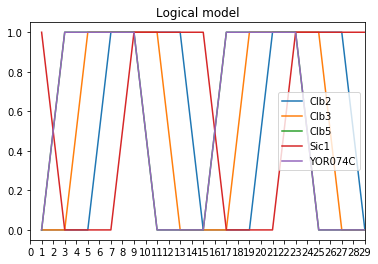

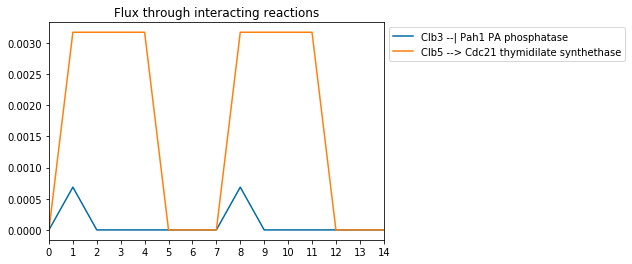

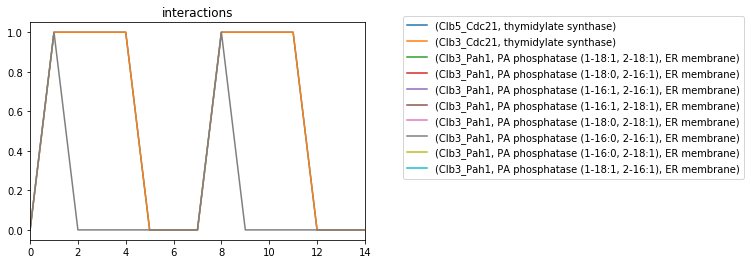

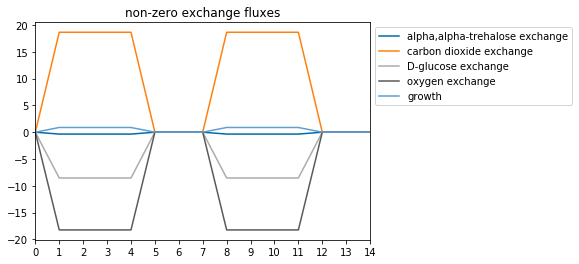

In [9]:
# display(bd_df_uneven0)
bool_plot = bd_df_uneven0.plot(xticks=range(len(bd_df_uneven0)*2),title="Logical model")

interactions_df = visualize.interactions(BC_intx.interactions,yeast7,flux_distr_df0)
# display(interactions_df)

interactions_max_s = interactions_df.abs().max()
interactions_df_norm = interactions_df / interactions_max_s

pah1_s = interactions_df['Clb3_Pah1'].sum(axis=1)
cdc21_s = interactions_df['Clb5_Cdc21']["thymidylate synthase"]

pah1_cdc21_df = pd.concat([pah1_s,cdc21_s],axis=1,keys=["Clb3 --| Pah1 PA phosphatase","Clb5 --> Cdc21 thymidilate synthethase"])
# display(pah1_cdc21_df)
pah1_cdc21_plot = pah1_cdc21_df.plot(title="Flux through interacting reactions",
                                     xticks=range(len(pah1_cdc21_df)),color=color_blind_hex[:2])
pah1_cdc21_plot.legend(bbox_to_anchor=(1, 1))
fig = pah1_cdc21_plot.get_figure()
fig.savefig("figures/interactions.png",bbox_inches='tight')


interactions_plot = interactions_df_norm.plot(title="interactions")
interactions_plot.legend(bbox_to_anchor=(1.1, 1.05))
# interactions_plot.title = "Interactions"
display(interactions_plot)


exchange_df = visualize.exchanges(yeast7,flux_distr_df0)
exchange_df = exchange_df[["alpha,alpha-trehalose exchange","carbon dioxide exchange","D-glucose exchange",
                           "oxygen exchange","growth"]]
exchange_max_s = exchange_df.abs().max()
exchange_df_norm = exchange_df / exchange_max_s
exchange_plot = exchange_df.plot(title = "non-zero exchange fluxes",
                                xticks=range(len(pah1_cdc21_df)),color=color_blind_hex[:len(pah1_cdc21_df)])
exchange_plot.legend(bbox_to_anchor=(1, 1)) 
fig = exchange_plot.get_figure()
fig.savefig("figures/non_zero_exchange.png",bbox_inches='tight')



In [10]:
KEGG_trends = { 
    "lipid_metabolism": ["Fatty acid biosynthesis","Fatty acid elongation","Fatty acid degradation",
                    "Synthesis and degradation of ketone bodies","Cutin, suberine and wax biosynthesis",
                   "Steroid biosynthesis","Primary bile acid biosynthesis","Secondary bile acid biosynthesis",
                   "Steroid hormone biosynthesis","Glycerolipid metabolism","Glycerophospholipid metabolism",
                   "Ether lipid metabolism","Sphingolipid metabolism","Arachidonic acid metabolism",
                   "Linoleic acid metabolism","alpha-Linolenic acid metabolism","Biosynthesis of unsaturated fatty acids",
                   "Lipid biosynthesis proteins"],
   "amino_acid_metabolism" : ["Alanine, aspartate and glutamate metabolism","Glycine, serine and threonine metabolism",
                 "Cysteine and methionine metabolism","Valine, leucine and isoleucine degradation",
                 "Valine, leucine and isoleucine biosynthesis","Lysine biosynthesis","Lysine degradation",
                 "Arginine biosynthesis","Arginine and proline metabolism","Histidine metabolism",
                 "Tyrosine metabolism","Phenylalanine metabolism","Tryptophan metabolism",
                    "Phenylalanine, tyrosine and tryptophan biosynthesis","Amino acid related enzymes"],
   "nucleotide_metabolism" : ["Purine metabolism","Pyrimidine metabolism"],
   "glycolysis" : ["Glycolysis / Gluconeogenesis"],
   "citrate_cycle" : ["Citrate cycle (TCA cycle)"],
               }

# for trend_name,path_id_lst in KEGG_trends.iteritems():
#     print path_id_lst
#     for rxn in yeast7.reactions[:100]:
#         print rxn.annotation['PATH']
#     #Retrieve list of rxns that are annotated with 1 or more paths from path_id_lst
#     rxn_ids = [ rxn.id for rxn in yeast7.reactions if not set(yeast7.reactions.get_by_id(rxn.id).annotation['PATH']).isdisjoint(path_id_lst)]
#     break
KEGG_trends_df = visualize.KEGG_trends(yeast7,flux_distr_df0,KEGG_trends)


,lipid_metabolism,nucleotide_metabolism,citrate_cycle,glycolysis,amino_acid_metabolism
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.390696,18.545014,29.134561,89.643787,55.537087
2,0.390010,18.545014,29.134561,89.643787,55.537087
3,0.390010,18.545014,29.134561,89.643787,55.537087
4,0.390010,18.545014,29.134561,89.643787,55.537087
5,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.390696,18.547999,29.134561,89.643787,55.537087
9,0.390010,18.545014,29.134561,89.643787,55.537087


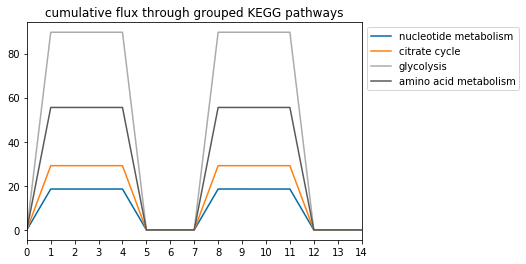

In [11]:
display(KEGG_trends_df)
KEGG_trends_df.columns = ["lipid metabolism","nucleotide metabolism","citrate cycle","glycolysis", "amino acid metabolism"]
KEGG_trends_plot = KEGG_trends_df[["nucleotide metabolism","citrate cycle","glycolysis","amino acid metabolism"]].plot(title=
                                   "cumulative flux through grouped KEGG pathways",xticks=range(len(pah1_cdc21_df)),color=color_blind_hex[:len(pah1_cdc21_df)])
KEGG_trends_plot.legend(bbox_to_anchor=(1, 1))   
fig = KEGG_trends_plot.get_figure()
fig.savefig("figures/KEGG_trends.png",bbox_inches='tight')
display(KEGG_trends_plot)


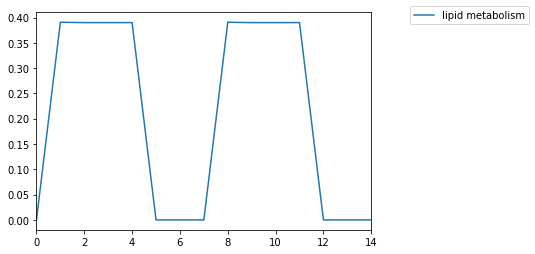

In [13]:
lipid_trend = KEGG_trends_df['lipid metabolism']
lipid_trend_plot = lipid_trend.plot()
lipid_trend_plot.legend(bbox_to_anchor=(1.1, 1.05)) 
display(lipid_trend_plot)

In [22]:
#Knock-out CDC21, and run simulation again
yeast7.genes.YOR074C.knock_out()
bool_data1, flux_distr_df1 = run(BC_intx.interactions,yeast7,Barberis_2_txt,rxn_order_in_file_name,solution_path,iterations=15)



Sic1 = True
Clb2 = False
Clb3 = False
Clb5 = False
YOR074C = False

Clb3*  = Clb5 and YOR074C
Clb2*  = Clb3
Sic1*  = Clb2
Clb5*  = not (Clb2 and Sic1)
YOR074C* = YOR074C



,Clb2,Clb3,Clb5,Sic1,Cdc21
0,False,False,False,True,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False
5,False,False,True,False,False
6,False,False,True,False,False
7,False,False,True,False,False
8,False,False,True,False,False
9,False,False,True,False,False


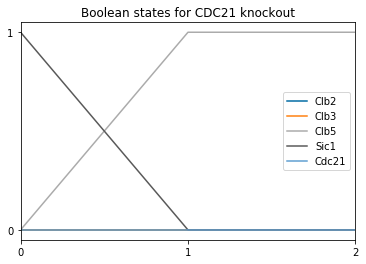

In [21]:
bd_df1 = pd.DataFrame.from_dict(bool_data1)
bd_df1.columns = ["Clb2","Clb3","Clb5","Sic1","Cdc21"]
bd_df_uneven1 = bd_df1.iloc[range(1,len(bd_df1),2)]
bd_df_uneven1.index = range(len(bd_df_uneven1))

display(bd_df_uneven1)

plot = bd_df_uneven1.iloc[:3].plot(title = "Boolean states for CDC21 knockout",xticks=range(3),yticks=[0,1], color=color_blind_hex[:len(bd_df_uneven1)])
fig = plot.get_figure()
fig.savefig("figures/bool_cdc21_knockout")